In [14]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on, file_mfccs, segments_from_audio_file
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.001

In [15]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
train_ds, val_ds, label_names = dataset_tf("dataset/osbh_sep_1", 0.8, 8)
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)

Found 130 files belonging to 2 classes.
Using 26 files for training.
Using 104 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (8, 4000)
Example label shape: (8,)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
513 44100


# Train

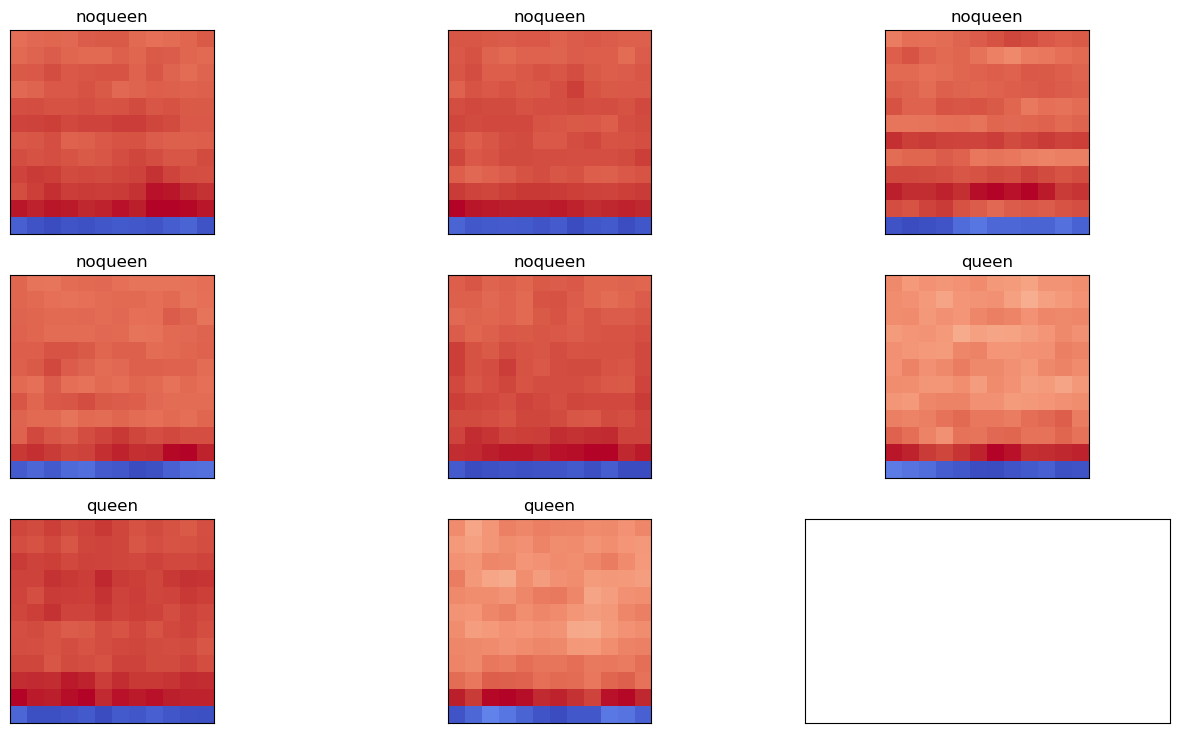

In [16]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [17]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
print(input_shape)
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

(12, 12, 1)


# EVAL

In [18]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3829 - loss: 8.0264  
MFCC Seq: [7.816076278686523, 0.38461539149284363]
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.3724 - loss: 1.2741
MFCC Conv: [1.2390694618225098, 0.375]


## Sequential

In [20]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

Epoch 1/10


ValueError: Unknown variable: <KerasVariable shape=(3, 3, 1, 32), dtype=float32, path=sequential_3/conv2d_12/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

## Convolutional

In [13]:

trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

Epoch 1/10


ValueError: Unknown variable: <KerasVariable shape=(3, 3, 1, 16), dtype=float32, path=conv2d_6/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

# Summary

In [8]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f},   VL: {history.history['val_loss'][-1]:.2f}, VA: {history.history['val_accuracy'][-1]:.2f}" )

history_to_summary("Trained MFCCs + Seq ", trained_history_mfcc_seq)
history_to_summary("Trained MFCCs + Conv", trained_history_mfcc_conv)

Trained MFCCs + Seq :    Loss: 0.43, Acc: 0.77,   VL: 0.86, VA: 0.54
Trained MFCCs + Conv:    Loss: 0.62, Acc: 0.81,   VL: 0.52, VA: 0.77
